# Deconvolve
### Dependencies

In [1]:
import numpy as np
import healpy as hp
import fitsio
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
import camb
from camb.sources import SplinedSourceWindow

In [3]:
nside = 1024
lmax = 1000

In [4]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67., omch2=0.270*0.67**2, ombh2=0.049*0.67**2)
pars.InitPower.set_params(As=2.1e-9, ns=0.96)
pars.Want_CMB = False 
pars.NonLinear = camb.model.NonLinear_both
                  #lmax
pars.set_for_lmax(2*lmax, lens_potential_accuracy=1);

In [5]:
z = np.linspace(0, 3, 300)
nz = np.exp(-((0.3-z)/0.1)**2)
bz = 0.83070341 + 1.19054721*z - 0.92835749*z**2 + 0.42329232*z**3
sources = []
sources += [
    SplinedSourceWindow(source_type='counts', z=z, W=nz, bias_z=bz),
    SplinedSourceWindow(source_type='lensing', z=z, W=nz)]
pars.SourceWindows = sources

In [6]:
results = camb.get_results(pars)
# lmax= 2*lmax+1
theory_cls = results.get_source_cls_dict(lmax=2*lmax, raw_cl=True)

l = np.arange(lmax+1)
fl = -np.sqrt((l+2)*(l+1)*l*(l-1))
fl /= np.clip(l*(l+1), 1, None)

l = np.arange(2*lmax+1)
fl2 = -np.sqrt((l+2)*(l+1)*l*(l-1))
fl2 /= np.clip(l*(l+1), 1, None)

In [7]:
theory_cls['W2xW2'] = theory_cls['W2xW2'] * fl2**2
theory_cls['W1xW2'] = theory_cls['W1xW2'] * fl2

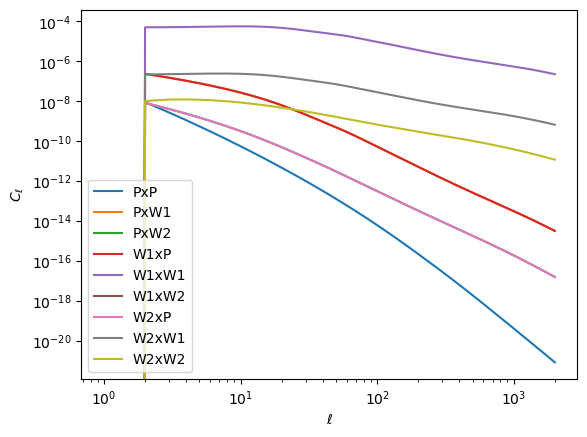

In [8]:
for key in list(theory_cls.keys()):
    plt.plot(theory_cls[key], label=key)
plt.legend()
plt.loglog()
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.show()

In [9]:
theory_map = hp.sphtfunc.synfast([
    theory_cls['W1xW1'],
    theory_cls['W2xW2'],
    np.zeros(2*lmax+1),
    theory_cls['W1xW2']],
    nside, new=True)
theory_map.shape

(3, 12582912)

In [10]:
mask = np.ones_like(theory_map[1])
pixel_theta, pixel_phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

#Patch
#mask[np.pi/3 > pixel_theta] = 0.0
#mask[pixel_theta > 2*np.pi/3] = 0.0
#mask[pixel_phi > np.pi/2] = 0.0
#mask[np.pi/8> pixel_phi] = 0.0

# One third cover
#mask[2*np.pi/3 > pixel_theta] = 0.0

# Half cover
#mask[np.pi/2 > pixel_theta] = 0.0

# two thirds cover
#mask[np.pi/3 > pixel_theta] = 0.0

# Euclid North
vmap_n = hp.read_map('/home/jaimerz/Documents/UCL/heracles/data/vmap_wlfs2_dr1n_vis24.5_nomag.fits')
vmap_n[vmap_n == hp.UNSEEN] = 0.
vmap_n = hp.ud_grade(vmap_n, nside)
mask *= vmap_n
# Euclid South
#vmap_s = hp.read_map('/home/jaimerz/Documents/UCL/heracles/data/vmap_wlfs2_dr1s_vis24.5_nomag.fits')
#vmap_s[vmap_s == hp.UNSEEN] = 0.
#vmap_s = hp.ud_grade(vmap_s, nside)
#mask *= vmap_s

# Euclid combined
#vmap = vmap_n + vmap_s
#mask *= vmap

maps = {('P', 0): theory_map[0]*mask,
        ('G', 0): np.array([theory_map[1]*mask, theory_map[2]*mask], np.dtype(float, metadata={'spin': 2})),}

list(maps.keys())

[('P', 0), ('G', 0)]

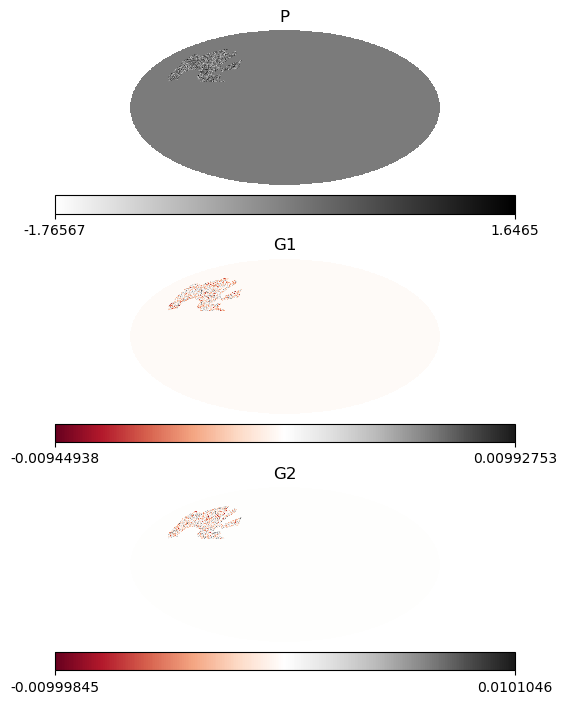

In [11]:
fig, ax = plt.subplots(3, figsize=(20, 7))
fig.tight_layout()
plt.sca(ax[0])
hp.mollview(maps[('P', 0)], cmap='binary', title='P', hold=True)
plt.sca(ax[1])
hp.mollview(maps[('G', 0)][0], cmap='RdGy', title='G1', hold=True)
plt.sca(ax[2])
hp.mollview(maps[('G', 0)][1], cmap='RdGy', title='G2', hold=True)
plt.show()

### Fields

In [12]:
from heracles.fields import Positions, Shears
from heracles.maps import Healpix

mapper = Healpix(nside, lmax)
fields = {
    "P": Positions(mapper, "RIGHT_ASCENSION", "DECLINATION", mask="V"),
    "G": Shears(mapper, "RIGHT_ASCENSION", "DECLINATION", "G1", "-G2", "WEIGHT", mask="W"),
}

### Alms

In [13]:
from heracles.maps import transform
alms = transform(fields, maps, progress=True)
list(alms.keys())

Output()

[('P', 0), ('G', 0)]

### Two-point statistics

In [14]:
from heracles.twopoint import angular_power_spectra, bin2pt
cls = angular_power_spectra(alms)
list(cls.keys())

[('P', 'P', 0, 0),
 ('P', 'G_E', 0, 0),
 ('P', 'G_B', 0, 0),
 ('G_E', 'G_E', 0, 0),
 ('G_E', 'G_B', 0, 0),
 ('G_B', 'G_B', 0, 0)]

### Binning

In [15]:
bin_edges = np.linspace(0, lmax, 31).astype(int)
B = np.diag(np.ones(lmax+1))
B = bin2pt(B, bin_edges, 'B')
binned_ls = B['L']
B = B['B']

In [16]:
bin_edges = np.linspace(0, lmax, 31).astype(int)
B = np.diag(np.ones(lmax+1))
B = bin2pt(B, bin_edges, 'B')
binned_ls = B['L']
B = B['B']

n, m = B.shape
B2 = np.zeros((n, 2*lmax+1))
B2[:, :lmax+1] = B

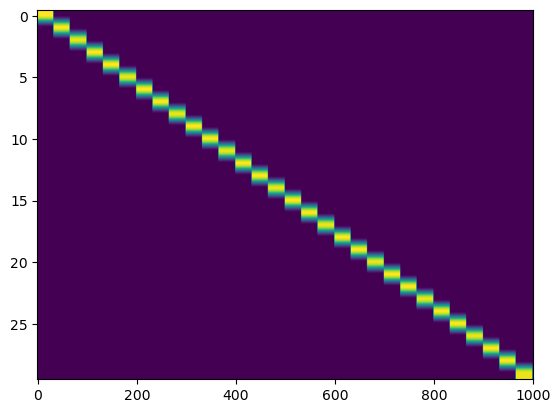

In [17]:
plt.imshow(B, aspect='auto')

## Mixing Matrix

In [18]:
from heracles.fields import Visibility, Weights
from heracles.twopoint import mixing_matrices
from heracles.maps import map_catalogs

In [19]:
mapper_mm = Healpix(2*nside, 2*lmax)
fields = {"P": Positions(None, mask="V"),
          "G": Shears(None, "RIGHT_ASCENSION", "DECLINATION", "G1", "-G2", "WEIGHT", mask="W"),
          "V": Visibility(mapper_mm),
          "W": Weights(mapper_mm, "RIGHT_ASCENSION", "DECLINATION", "WEIGHT")}
masks = {("V", 0): mask,
         ("W", 0): mask}
mask_alms = transform(fields, masks, progress=True)
mask_cls = angular_power_spectra(mask_alms)
mms = mixing_matrices(fields, mask_cls,
    l3max=2*lmax+lmax, l2max=2*lmax, l1max=lmax, progress=True)

Output()

Output()

In [20]:
fields_a = np.unique([i[0] for i in mms.keys()])
fields_b = np.unique([i[1] for i in mms.keys()])
translator = {'P': 'W1', 'G_E': 'W2', 'G_B': 'W2'}

('G_B', 'G_B', 0, 0) W2xW2
('G_E', 'G_B', 0, 0) W2xW2
('G_E', 'G_E', 0, 0) W2xW2
('P', 'G_E', 0, 0) W1xW2
('P', 'P', 0, 0) W1xW1


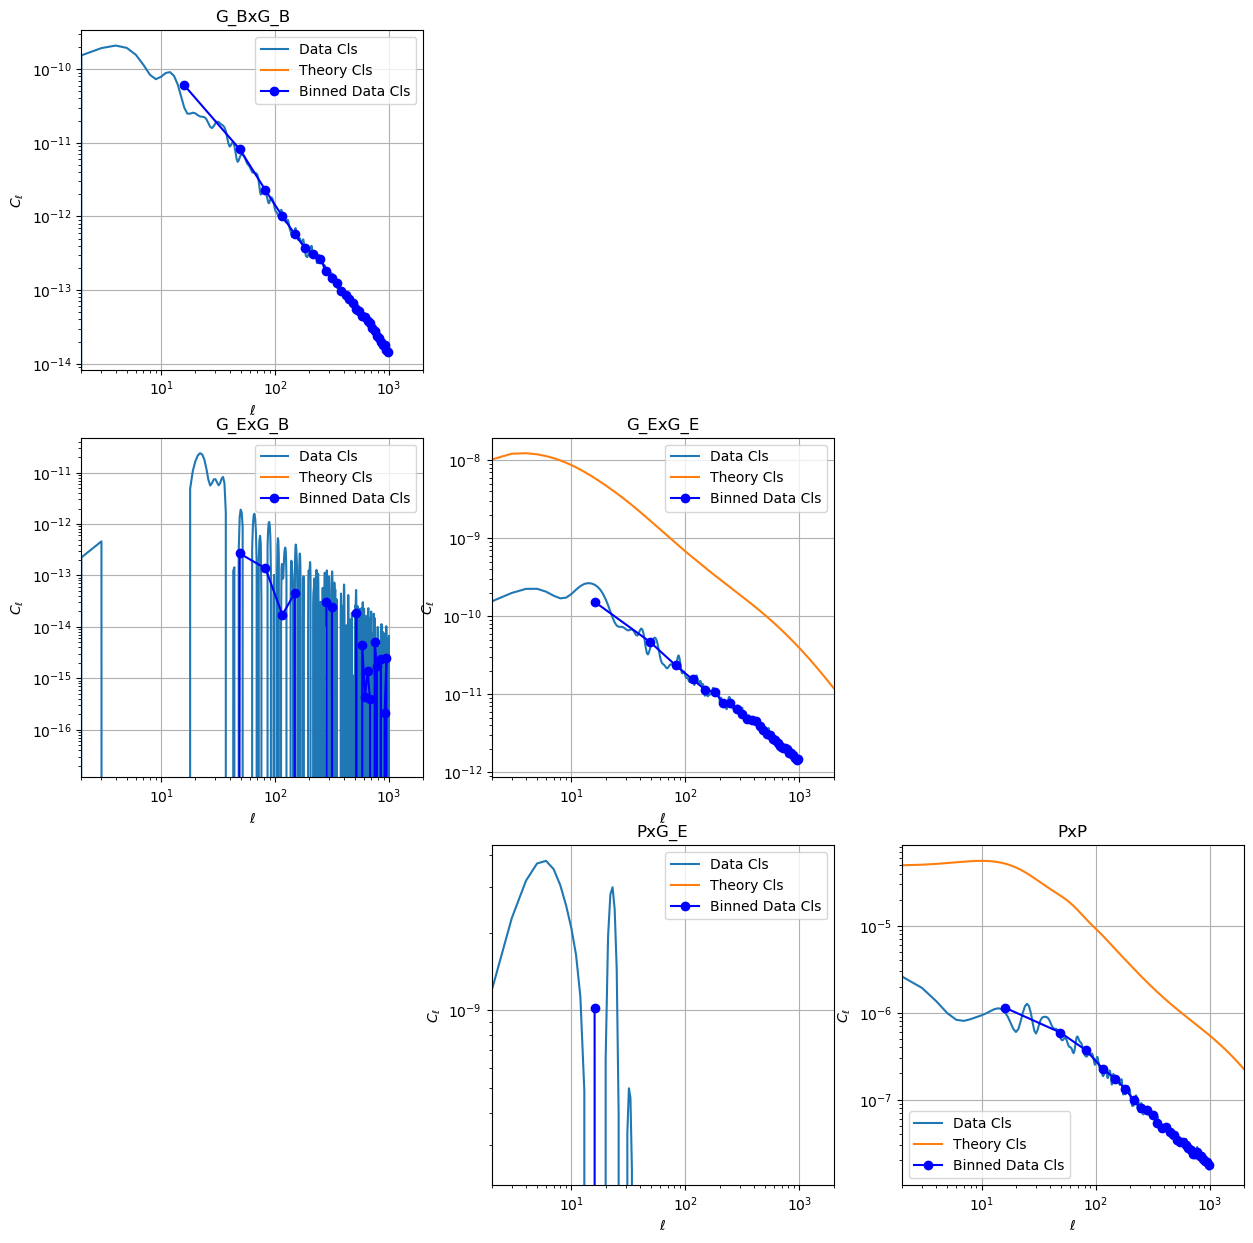

In [21]:
figure, axis = plt.subplots(3, 3, figsize=(5*3, 5*3))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1, s2, 0, 0)
        if proposed_key in list(mms.keys()):
            print(proposed_key, f"{translator[s1]}x{translator[s2]}") 
            if s1 == "G_B" or s2 == "G_B":
                t = np.zeros(2*lmax+1)
            else:
                t = theory_cls[f"{translator[s1]}x{translator[s2]}"]
            d = cls[proposed_key]

            axis[i, j].plot(d, label="Data Cls")
            axis[i, j].plot(t, label="Theory Cls")
            axis[i, j].plot(binned_ls, B@d, "bo-", label="Binned Data Cls")
            axis[i, j].set_xscale('log')
            axis[i, j].set_yscale('log')
            axis[i, j].set_title(f"{s1}x{s2}")
            axis[i, j].set_xlabel(r"$\ell$")
            axis[i, j].set_ylabel(r"$C_\ell$")
            axis[i, j].grid()
            axis[i, j].set_xlim(2, 2*lmax)
            axis[i, j].legend()
        else:
            axis[i, j].axis('off')
plt.show()

## Pulse Wise

In [22]:
import transformcl
import wigner

In [23]:
def cl2corr_mat(theta, lmax=None, spin1=0, spin2=0):
    if lmax is None:
        lmax = len(theta) - 1
    m = np.empty((len(theta), lmax + 1))
    f = (2 * np.arange(lmax + 1) + 1) / (4 * np.pi)
    for i, t in enumerate(theta):
        m[i] = f * wigner.wigner_dl(0, lmax, spin1, spin2, t)
    return m

def corr2cl_solve(mat, corr, spin1=0, spin2=0):
    k = max(abs(spin1), abs(spin2))
    cut_mat = mat[:, k:]
    return np.pad(np.linalg.solve(cut_mat, corr), (k, 0))

def corr2cl_lstsq(mat, corr):
    return np.linalg.lstsq(mat, corr, None)[0]

In [24]:
def apodize(x, x0=-2, k=50):
    return (1+np.exp(-k*(x-x0)))

Fm = transformcl.cltocorr(mask_cls[('V', 'V', 0, 0)][:1001])
Fm_full = transformcl.cltocorr(mask_cls[('V', 'V', 0, 0)])
Fm_apo = (Fm* apodize(np.log10(np.abs(Fm))))
Fm_apo_full = (Fm_full * apodize(np.log10(np.abs(Fm_full))))

In [26]:
cl_EE = cls[('G_E', 'G_E', 0, 0)]
cl_BB = cls[('G_B', 'G_B', 0, 0)]
cl_EB = cls[('G_E', 'G_B', 0, 0)]
th = transformcl.theta(2*lmax+1)

mat_p = cl2corr_mat(th, lmax, 2, 2)
mat_m = cl2corr_mat(th, lmax, 2, -2)

xi_m = mat_m @ (cl_EE - cl_BB) #- 2j*cl_EB)
xi_p = mat_p @ (cl_EE + cl_BB)
xi = mat_m @ (cl_EE + cl_BB)
xi_dec = xi/Fm_apo_full # xi*g

xi_B = mat_m @ cl_BB
xi_E = mat_m @ cl_EE

In [29]:
cl_plus  = corr2cl_lstsq(mat_p, (1/Fm_apo_full) * (mat_p @ (cl_EE + cl_BB)))
cl_minus = corr2cl_lstsq(mat_m, (1/Fm_apo_full) * (mat_m @ (cl_EE - cl_BB)))

cl_E = 0.5*(cl_plus + cl_minus)
cl_B = 0.5*(cl_plus - cl_minus)

In [30]:
cl_e_p_cl_b = corr2cl_lstsq(mat_m, xi_dec)
cl_e_m_cl_b = corr2cl_lstsq(mat_m, xi_m/Fm_apo_full)

dec_cl_b = 0.5 * (cl_e_p_cl_b - cl_e_m_cl_b)
dec_cl_e = 0.5 * (cl_e_p_cl_b + cl_e_m_cl_b)

In [31]:
dec_cl_bb = corr2cl_lstsq(mat_m, 0.5*(xi-xi_m)/Fm_apo_full) # 0.5*(xi-xi_m)*g
dec_cl_ee = corr2cl_lstsq(mat_m, 0.5*(xi+xi_m)/Fm_apo_full) # 0.5*(xi+xi_m)*g

#dec_cl_e = corr2cl_solve(mat_m, xi_E/Fm_apo, 2, -2)
#dec_cl_b = corr2cl_solve(mat_m, xi_B/Fm_apo, 2, -2)

('G_B', 'G_B', 0, 0) W2xW2
('G_E', 'G_B', 0, 0) W2xW2
('G_E', 'G_E', 0, 0) W2xW2
('P', 'G_E', 0, 0) W1xW2
('P', 'P', 0, 0) W1xW1


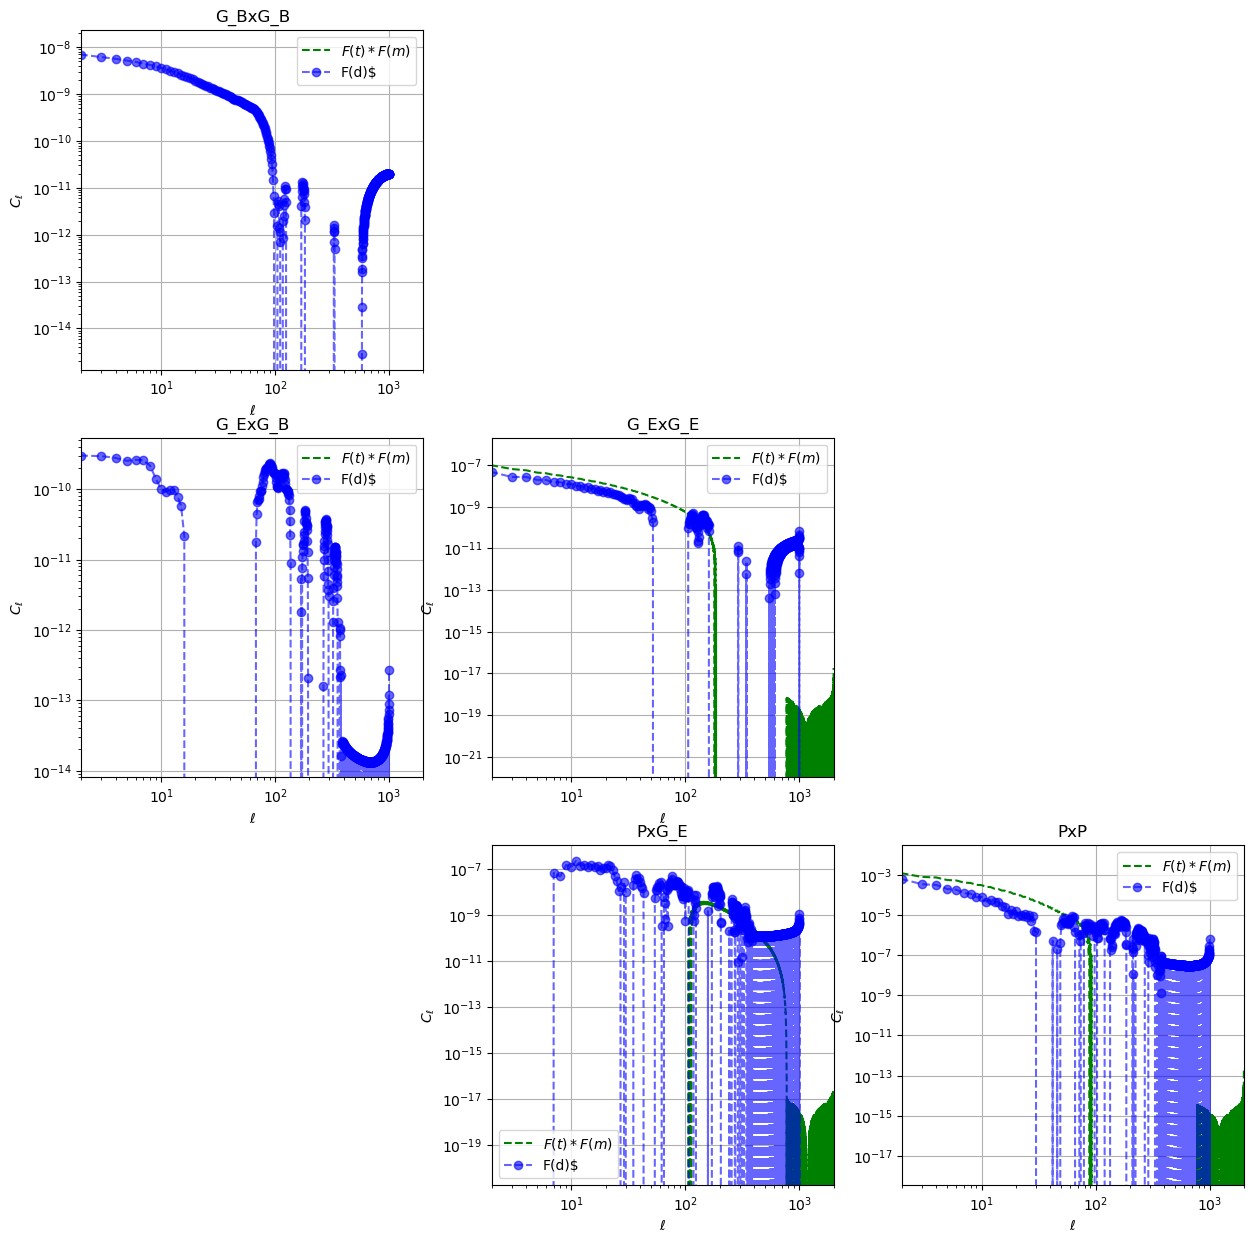

In [32]:
figure, axis = plt.subplots(3, 3, figsize=(5*3, 5*3))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1, s2, 0, 0)
        if proposed_key in list(mms.keys()):
            print(proposed_key, f"{translator[s1]}x{translator[s2]}")        
            if s1 == "G_B" or s2 == "G_B":
                t = np.zeros(2*lmax+1)
            else:
                t = theory_cls[f"{translator[s1]}x{translator[s2]}"]
            d = cls[proposed_key]
            Ft = transformcl.cltocorr(t)
            Fd = transformcl.cltocorr(d)

            axis[i, j].plot(Ft*Fm_full, 'g--', label="$F(t)*F(m)$")
            axis[i, j].plot(Fd, 'bo--', alpha=0.6, label=r"F(d)$")
            axis[i, j].set_xscale('log')
            axis[i, j].set_yscale('log')
            axis[i, j].set_title(f"{s1}x{s2}")
            axis[i, j].set_xlabel(r"$\ell$")
            axis[i, j].set_ylabel(r"$C_\ell$")
            axis[i, j].grid()
            axis[i, j].set_xlim(2, 2*lmax)
            axis[i, j].legend()
        else:
            axis[i, j].axis('off')
plt.show()

('G_B', 'G_B', 0, 0) W2xW2
('G_E', 'G_B', 0, 0) W2xW2
('G_E', 'G_E', 0, 0) W2xW2
('P', 'G_E', 0, 0) W1xW2
('P', 'P', 0, 0) W1xW1


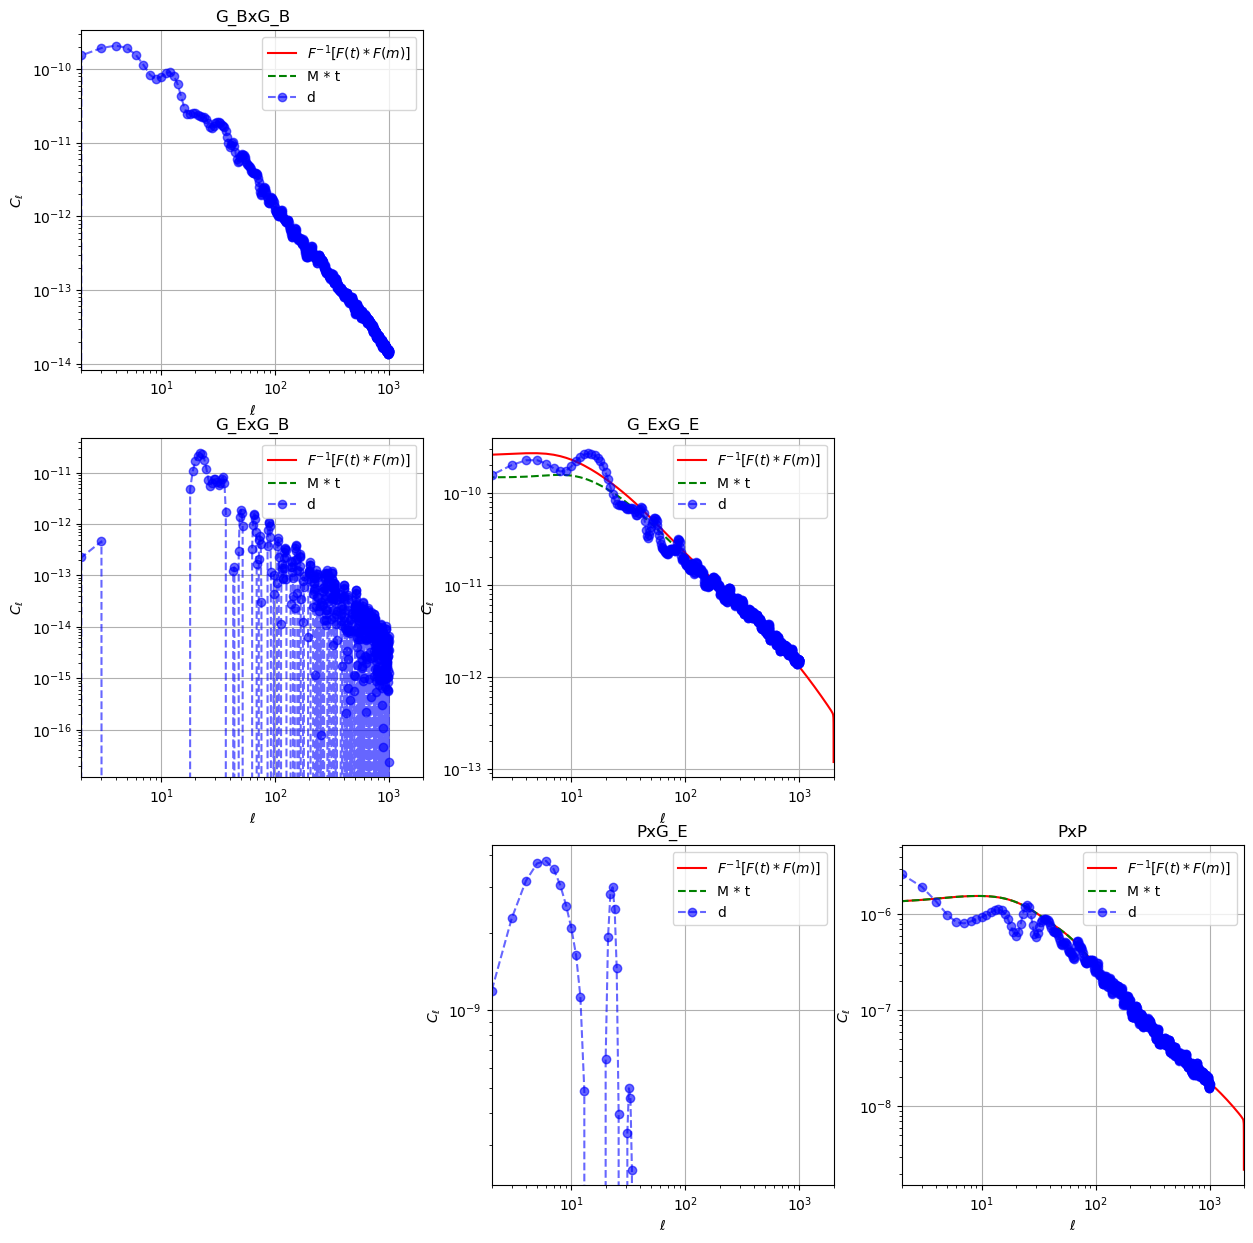

In [33]:
figure, axis = plt.subplots(3, 3, figsize=(5*3, 5*3))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1, s2, 0, 0)
        if proposed_key in list(mms.keys()):
            print(proposed_key, f"{translator[s1]}x{translator[s2]}") 
            if s1 == "G_B" or s2 == "G_B":
                t = np.zeros(2*lmax+1)
            else:
                t = theory_cls[f"{translator[s1]}x{translator[s2]}"]
            d = cls[proposed_key]
            M = mms[proposed_key]
            Ft = transformcl.cltocorr(t)
            Fd = transformcl.cltocorr(d)

            axis[i, j].plot(transformcl.corrtocl(Ft*Fm_full), 'r-', 
                            label=r"$F^{-1}[F(t)*F(m)]$")
            axis[i, j].plot(M @ t, 'g--', label="M * t")
            axis[i, j].plot(d, 'bo--', alpha=0.6, label="d")
            axis[i, j].set_xscale('log')
            axis[i, j].set_yscale('log')
            axis[i, j].set_title(f"{s1}x{s2}")
            axis[i, j].set_xlabel(r"$\ell$")
            axis[i, j].set_ylabel(r"$C_\ell$")
            axis[i, j].grid()
            axis[i, j].set_xlim(2, 2*lmax)
            axis[i, j].legend()
        else:
            axis[i, j].axis('off')
plt.show()

('G_B', 'G_B', 0, 0) W2xW2
(1001,) (2001,) (1001,)
('G_E', 'G_B', 0, 0) W2xW2
(1001,) (2001,) (1001,)
('G_E', 'G_E', 0, 0) W2xW2
(1001,) (2001,) (1001,)
('P', 'G_E', 0, 0) W1xW2
(1001,) (2001,) (1001,)
('P', 'P', 0, 0) W1xW1
(1001,) (2001,) (1001,)


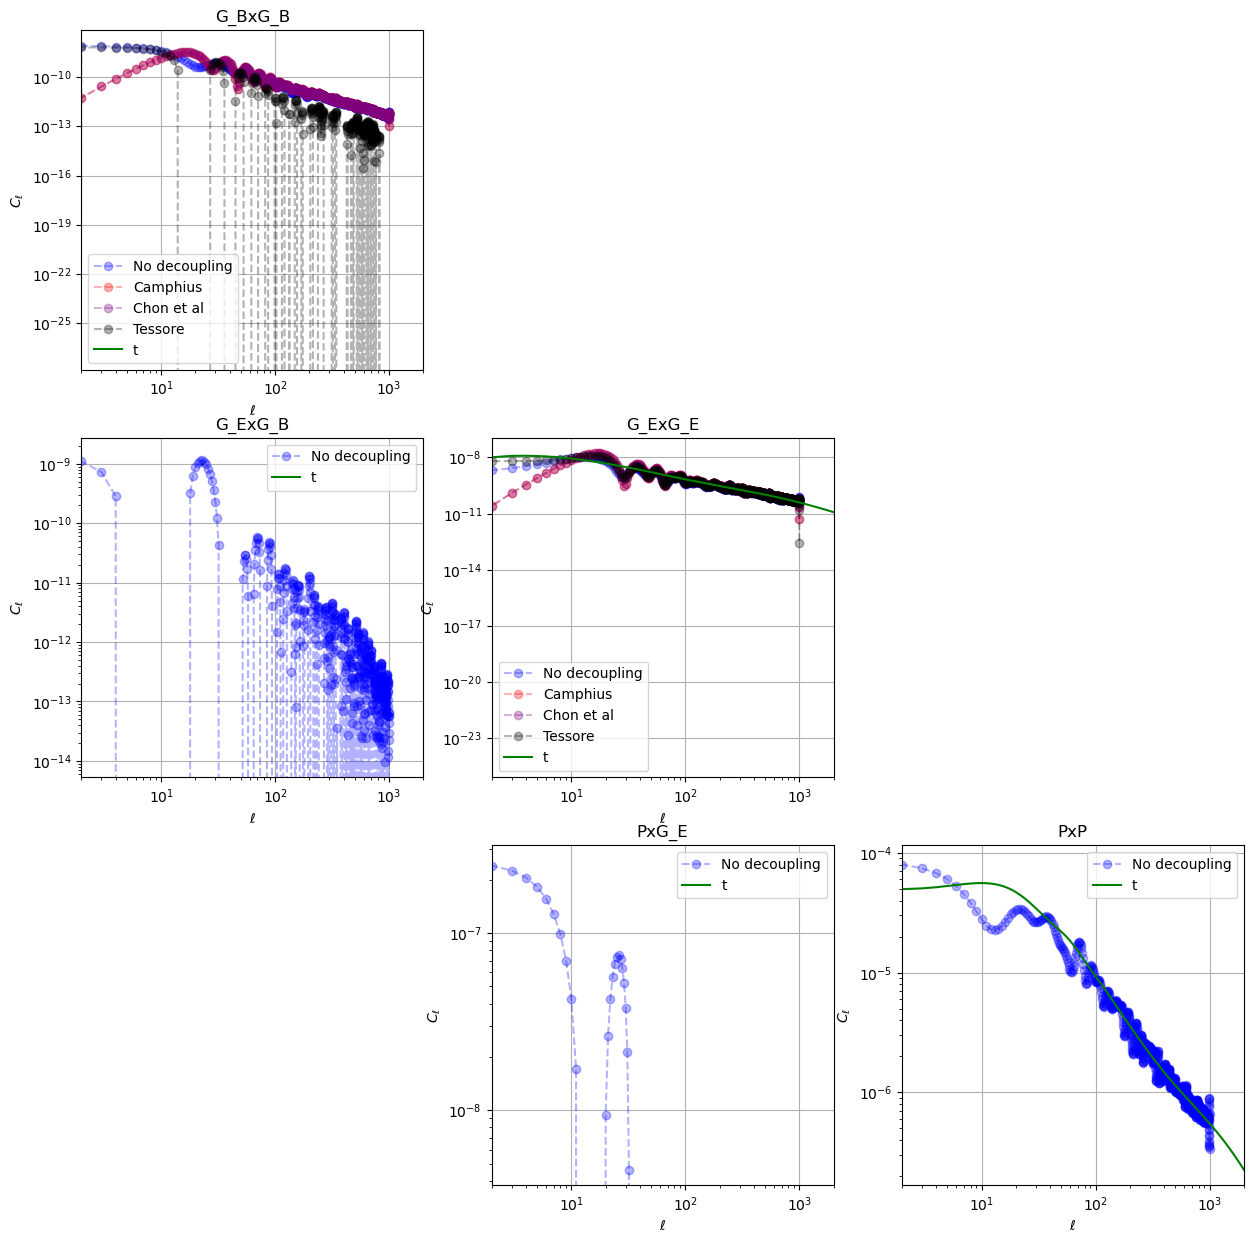

In [34]:
figure, axis = plt.subplots(3, 3, figsize=(5*3, 5*3))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1, s2, 0, 0)
        if proposed_key in list(mms.keys()):
            print(proposed_key, f"{translator[s1]}x{translator[s2]}") 
            if s1 == "G_B" or s2 == "G_B":
                t = np.zeros(2*lmax+1)
            else:
                t = theory_cls[f"{translator[s1]}x{translator[s2]}"]
            d = cls[proposed_key]
            M = mms[proposed_key]
            Ft = transformcl.cltocorr(t)
            Fd = transformcl.cltocorr(d)

            print(Fd.shape, Ft.shape, Fm.shape)
            axis[i, j].plot(transformcl.corrtocl(Fd/Fm_apo), 
                            'bo--', alpha=0.3, 
                            label="No decoupling")

            if proposed_key == ('G_B', 'G_B', 0, 0):
                axis[i, j].plot(dec_cl_b, 'ro--', alpha=0.3, label="Camphius")
                axis[i, j].plot(dec_cl_bb, 'o--', color='purple', alpha=0.3, label="Chon et al")
                axis[i, j].plot(cl_B, 'ko--', alpha=0.3, label="Tessore")

            if proposed_key == ('G_E', 'G_E', 0, 0):
                axis[i, j].plot(dec_cl_e, 'ro--', alpha=0.3, label="Camphius")
                axis[i, j].plot(dec_cl_ee, 'o--', color='purple', alpha=0.3, label="Chon et al")
                axis[i, j].plot(cl_E, 'ko--', alpha=0.3, label="Tessore")
            
            axis[i, j].plot(t, 'g-', label="t")
            axis[i, j].set_xscale('log')
            axis[i, j].set_yscale('log')
            axis[i, j].set_title(f"{s1}x{s2}")
            axis[i, j].set_xlabel(r"$\ell$")
            axis[i, j].set_ylabel(r"$C_\ell$")
            axis[i, j].grid()
            axis[i, j].set_xlim(2, 2*lmax)
            axis[i, j].legend()
        else:
            axis[i, j].axis('off')
plt.show()

('G_B', 'G_B', 0, 0) W2xW2
('G_E', 'G_B', 0, 0) W2xW2
('G_E', 'G_E', 0, 0) W2xW2
('P', 'G_E', 0, 0) W1xW2
('P', 'P', 0, 0) W1xW1


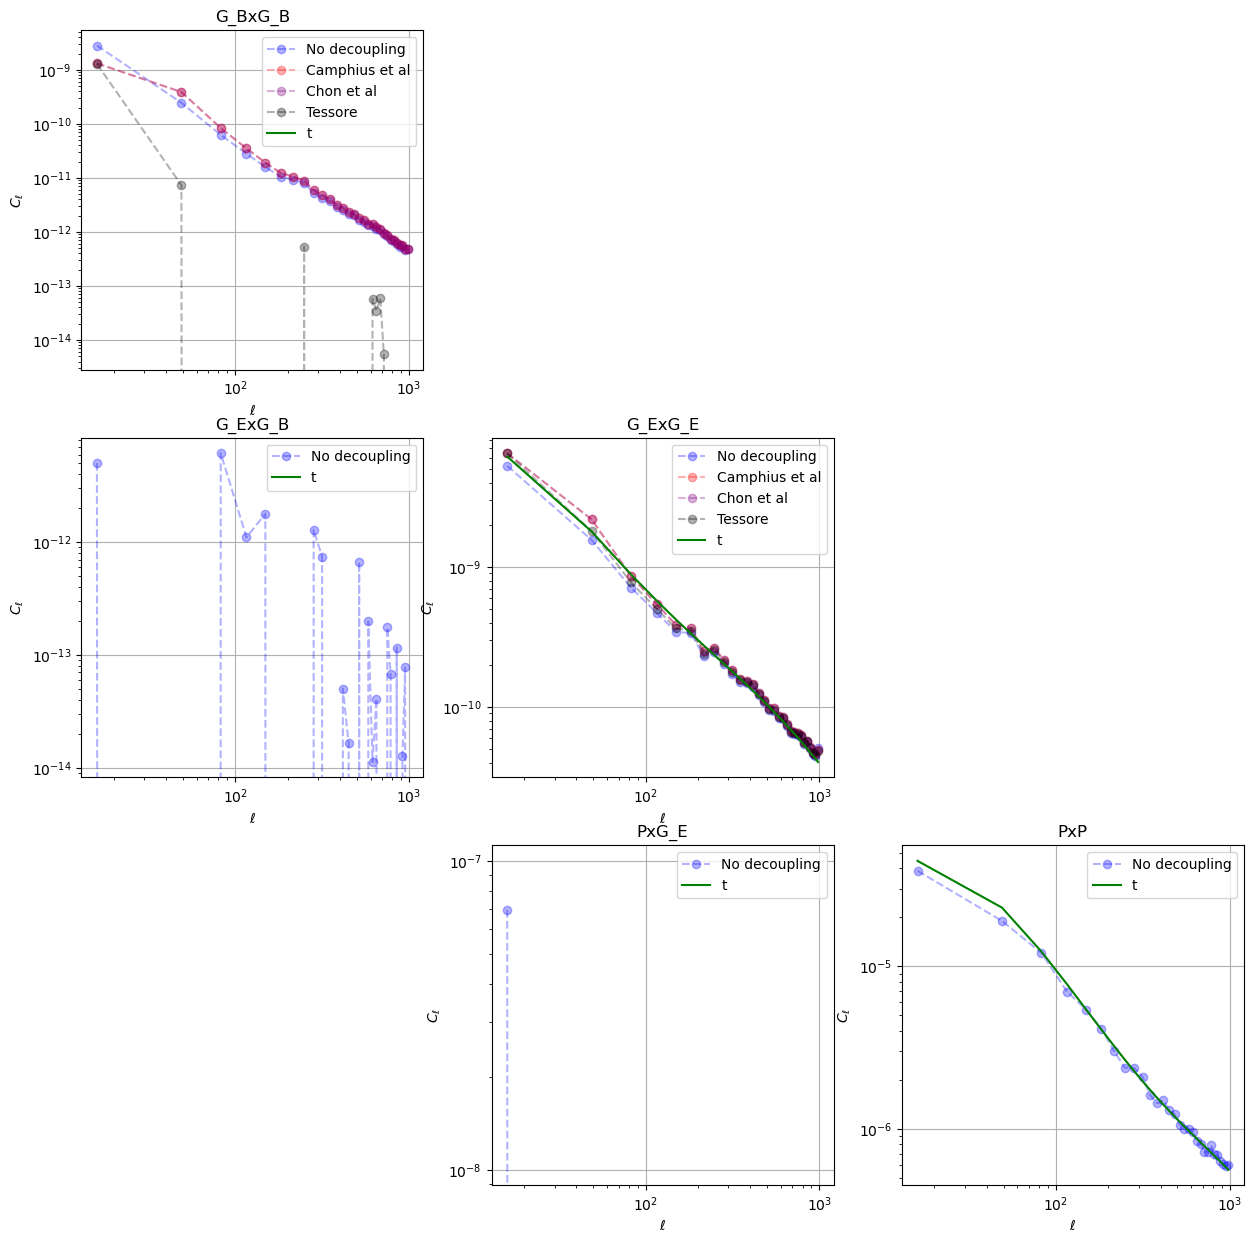

In [36]:
figure, axis = plt.subplots(3, 3, figsize=(5*3, 5*3))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1, s2, 0, 0)
        if proposed_key in list(mms.keys()):
            print(proposed_key, f"{translator[s1]}x{translator[s2]}") 
            if s1 == "G_B" or s2 == "G_B":
                t = np.zeros(2*lmax+1)
            else:
                t = theory_cls[f"{translator[s1]}x{translator[s2]}"]
            d = cls[proposed_key]
            M = mms[proposed_key]
            Ft = transformcl.cltocorr(t)
            Fd = transformcl.cltocorr(d)

            axis[i, j].plot(B2 @ l, B @ transformcl.corrtocl(Fd/(Fm_apo)), 
                            'bo--', alpha=0.3, 
                            label="No decoupling")
            
            if proposed_key == ('G_B', 'G_B', 0, 0):
                axis[i, j].plot(B2 @ l, B @ dec_cl_b, 'ro--', alpha=0.3, label="Camphius et al")
                axis[i, j].plot(B2 @ l, B @ dec_cl_bb, 'o--', color='purple', alpha=0.3, label="Chon et al")
                axis[i, j].plot(B2 @ l, B @ cl_B, 'ko--', alpha=0.3, label="Tessore")

            if proposed_key == ('G_E', 'G_E', 0, 0):
                axis[i, j].plot(B2 @ l, B @ dec_cl_e, 'ro--', alpha=0.3, label="Camphius et al")
                axis[i, j].plot(B2 @ l, B @ dec_cl_ee, 'o--', color='purple', alpha=0.3, label="Chon et al")
                axis[i, j].plot(B2 @ l, B @ cl_E, 'ko--', alpha=0.3, label="Tessore")
            
            axis[i, j].plot(B2 @ l, B2 @ t, 'g-', label="t")
            axis[i, j].set_xscale('log')
            axis[i, j].set_yscale('log')
            axis[i, j].set_title(f"{s1}x{s2}")
            axis[i, j].set_xlabel(r"$\ell$")
            axis[i, j].set_ylabel(r"$C_\ell$")
            axis[i, j].grid()
            axis[i, j].legend()
        else:
            axis[i, j].axis('off')
plt.show()